In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from PIL import Image
from PIL import ImageOps
import os
import numpy as np

# Image preprocessing

In [2]:
original_images_dir = './images/original_dataset'
images_dir = './images/dataset'

for image_name in os.listdir(original_images_dir):
    image = Image.open(original_images_dir + '/' + image_name).convert('L')
    image = ImageOps.exif_transpose(image)
    image = image.resize((128, 128))
    image.save(images_dir + '/' + image_name)

# Prepare the dataset

In [3]:
dataset = []
labels = []
for image_name in os.listdir(images_dir):
    labels += [image_name.split("_")[0]]
    im = np.array(Image.open(images_dir + '/' + image_name))
    im = im.flatten()
    dataset += [im]

original_shape = np.array(Image.open(images_dir + '/' + os.listdir(images_dir)[0])).shape

labels = np.array(labels)
prepared_data = np.array(dataset)

print(original_shape)
print(prepared_data[0].shape)

(128, 128)
(16384,)


In [4]:
def array_to_image(image_array, shape, fun=None):
    image = (np.reshape(image_array, original_shape))
    if fun is not None:
        image = fun(image)
    image = Image.fromarray(image).convert('RGB')
    return image

def plot_sample(data, labels, title, show_title=True, n_cols=6):
    n_cols = n_cols
    n_rows = int(np.ceil(len(set(labels)) / n_cols))
    
    plt.rcParams['figure.figsize'] = [12, 2.4 * n_rows + (0.5 if show_title else 0.0)]
    plt.rcParams['font.size'] = 16
    
    used_labels = set()
    subplot_idx = 1
    for image, label in zip(data, labels):
        if label not in used_labels:
            used_labels.add(label)
            plt.subplot(n_rows, n_cols, subplot_idx)
            subplot_idx += 1
            plt.title(label)
            plt.axis('off')
            plt.tight_layout()
            plt.imshow(image.reshape(original_shape), cmap='gray')
    
    if show_title:
        plt.suptitle(title)
    plt.savefig(f'./images/{title.replace("-", "").replace(" ", "_").lower()}.jpg')
    plt.show()
    
def show_image(image_array, shape, title):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(image_array.reshape(shape), cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'./images/{title.replace("-", "").replace(" ", "_").lower()}.jpg')

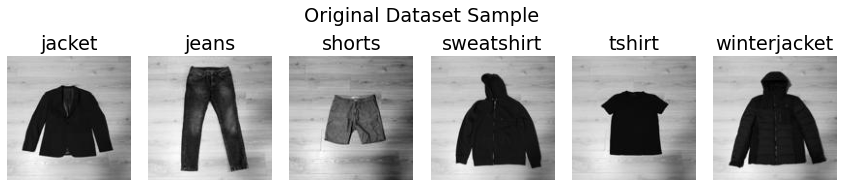

In [5]:
plot_sample(prepared_data, labels, 'Original Dataset Sample')

# PCA

## Centering the data

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=False)
centered_data = scaler.fit_transform(prepared_data)
mean_image = scaler.mean_
print(f'Mean before: {mean_image[:4]}')
print(f'Mean after: {centered_data.mean(axis=0)[:4]}')

Mean before: [174.72222222 175.52777778 176.88888889 178.55555556]
Mean after: [-6.31593543e-15  6.31593543e-15  3.15796771e-15  1.26318709e-14]


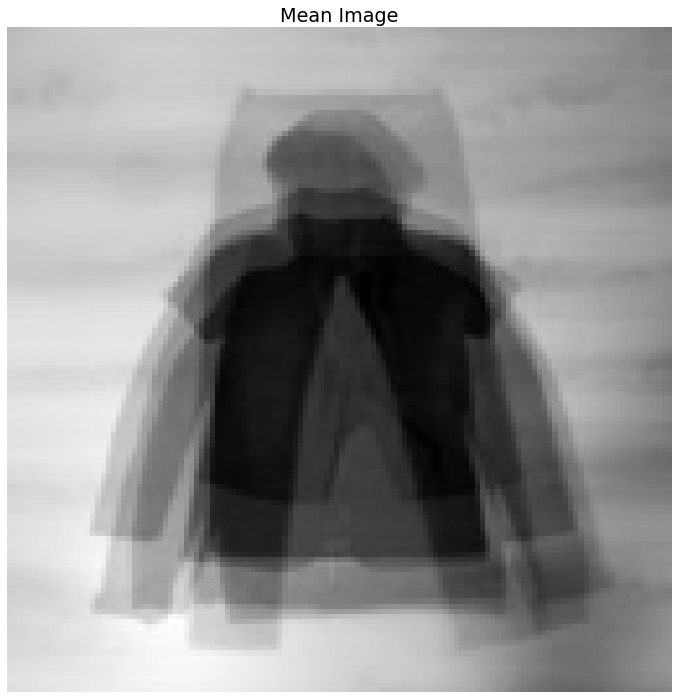

In [7]:
show_image(mean_image, original_shape, 'Mean Image')

## Components

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca_data = pca.fit_transform(centered_data)

In [9]:
components = pca.components_
print(components.shape)
print(components[0])

(36, 16384)
[-0.00101246 -0.00105227 -0.00107539 ...  0.0019774   0.00218771
  0.0023994 ]


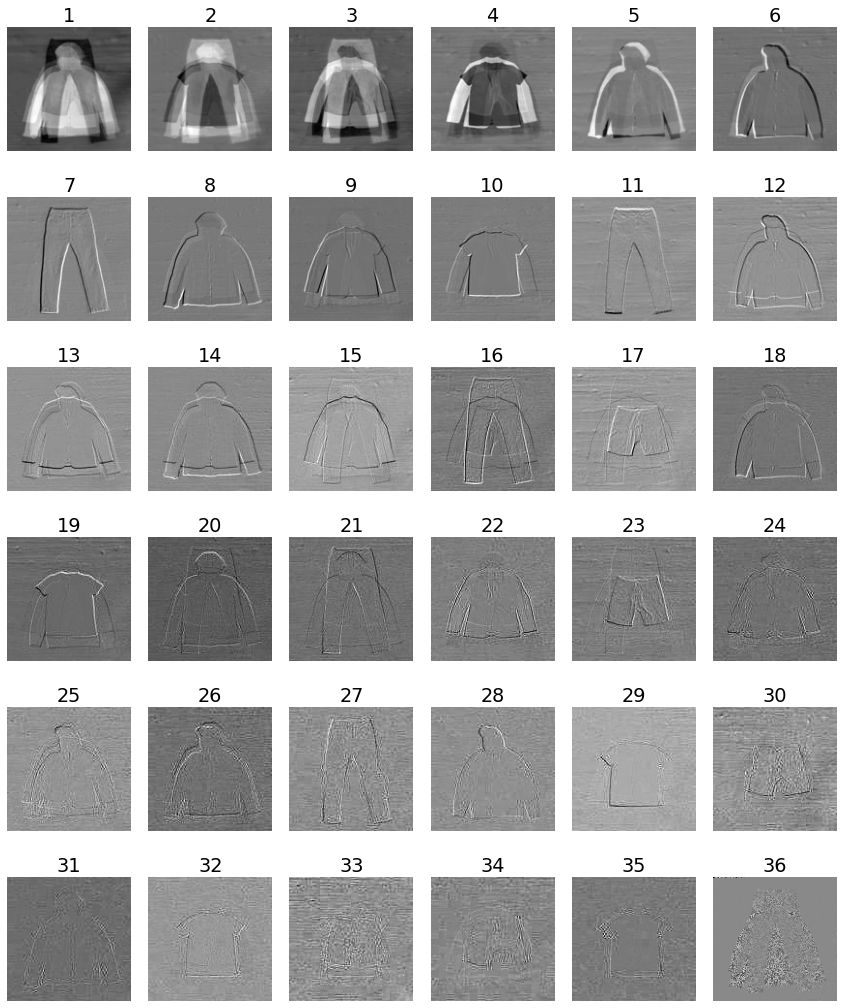

In [10]:
plot_sample(components, np.arange(1, len(components) + 1), 'Components', False)

## Explained variance ratio

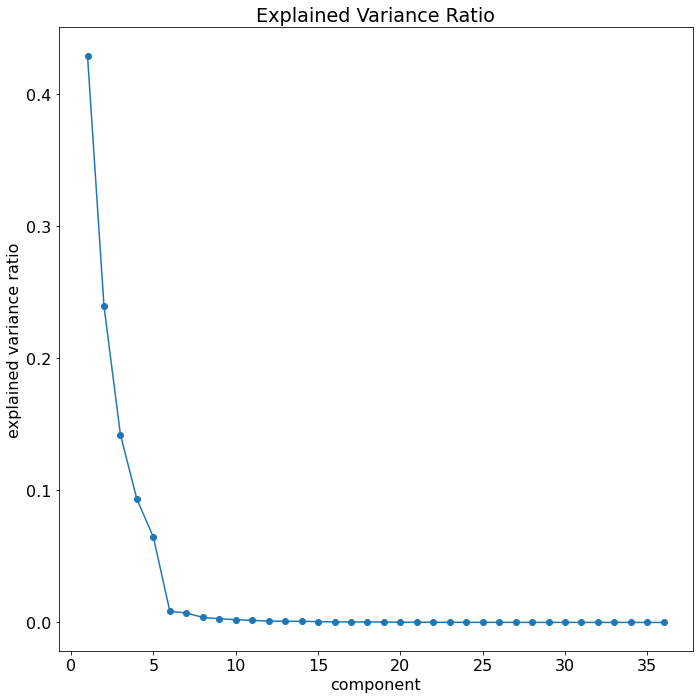

In [11]:
plt.rcParams['figure.figsize'] = [10, 10]

explained_variance_ratio = pca.explained_variance_ratio_
x = np.arange(1, len(explained_variance_ratio) + 1)

plt.plot(x, explained_variance_ratio, marker='o')
plt.xlabel('component')
plt.ylabel('explained variance ratio')
plt.title('Explained Variance Ratio')

plt.tight_layout()
plt.savefig('./images/variance.jpg')
plt.show()

## 4 dimensions

In [12]:
def reduce_dims(data, labels, n_components):
    pca_n = PCA(n_components=n_components)
    pca_n_data = pca_n.fit_transform(centered_data)
    pca_n_inversed = pca_n.inverse_transform(pca_n_data) + mean_image
    
    plot_sample(pca_n_inversed, labels, f'PCA - {n_components} dims')
    
    return pca_n_inversed

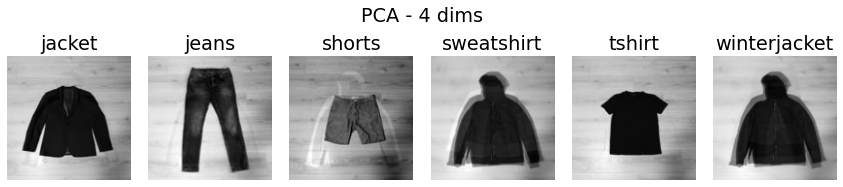

In [13]:
data_4_dims = reduce_dims(centered_data, labels, 4)

## 16 dimensions

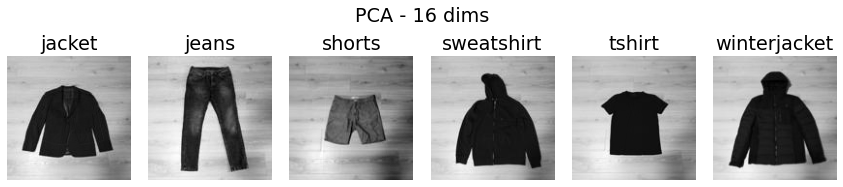

In [14]:
data_16_dims = reduce_dims(centered_data, labels, 16)

## 7 dimensions

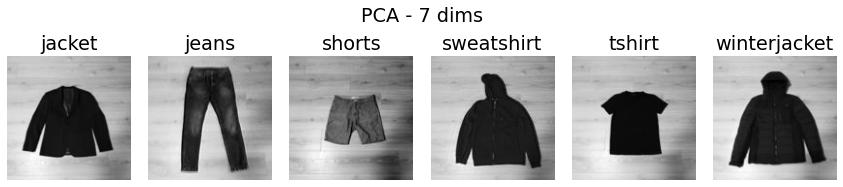

In [15]:
data_7_dims = reduce_dims(centered_data, labels, 7)

## 2 dimensions

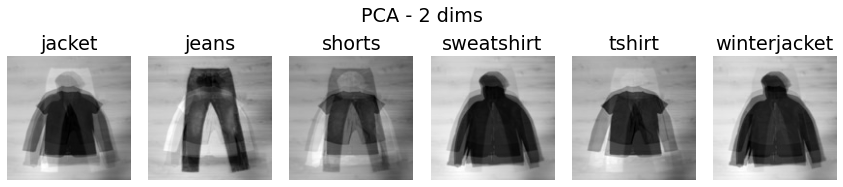

In [16]:
data_2_dims = reduce_dims(centered_data, labels, 2)

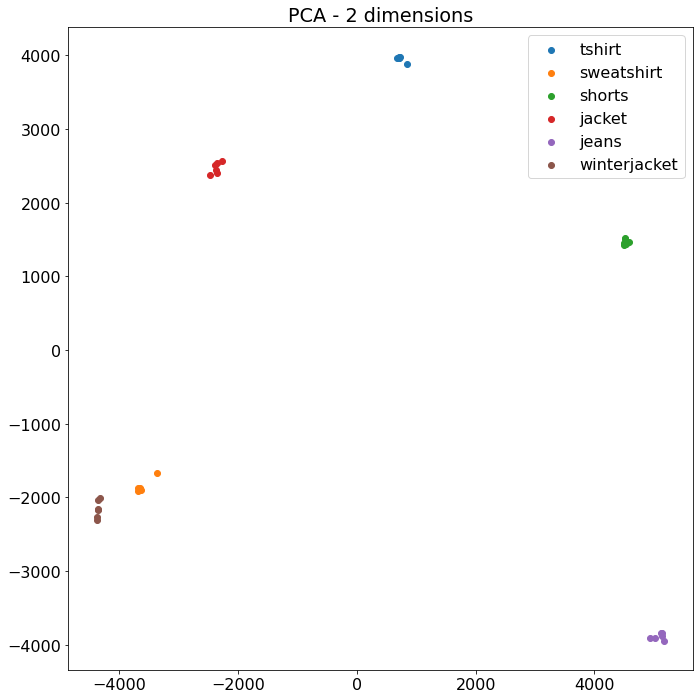

In [17]:
plt.rcParams['figure.figsize'] = [10, 10]

pca_2 = PCA(n_components=2)
pca_2_data = pca_2.fit_transform(centered_data)

for label in set(labels):
    data = pca_2_data[labels == label]
    plt.scatter(data[:, 0], data[:, 1], label=label)

plt.title('PCA - 2 dimensions')
plt.tight_layout()
plt.legend()
plt.savefig('./images/2_dims')
plt.show()